In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis, norm
#from sklearn.cluster import DBSCAN, HDBSCAN
#from sklearn.preprocessing import quantile_transform
import blimpy as bl
import setigen as stg
from astropy import units as u
import os
import psutil
%matplotlib inline

In [2]:
arrays = glob.glob('/datax/scratch/benjb/C23_L_M31_injections/*.npy')
for arr in arrays:
    print(arr)

/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc74.npy
/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc73.npy
/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc75.npy
/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc72.npy
/datax/scratch/benjb/C23_L_M31_injections/M31_retrieval_dat_paths.npy
/datax/scratch/benjb/C23_L_M31_injections/M31_retrieval_params.npy


In [38]:
print(arrays[1])
freqs = np.load(arrays[1])[0]
drifts = np.load(arrays[1])[1]
print(freqs[:20])
print(drifts[:20])

/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc73.npy
[1624.66210002 1622.08100204 1559.15871788 1504.84992726 1502.40080825
 1520.91682173 1562.25884856 1528.00670105 1560.26152007 1625.97082199
 1512.16693527 1513.65495611 1590.47675324 1529.03070745 1545.58741413
 1660.2082934  1663.334128   1668.13895939 1650.49167078 1540.53268906]
[ 1.42443969  0.40545416 -1.39442261 -0.29175304  1.44706481 -1.86464006
 -0.55558261  0.27228557  1.46040765 -1.35182746 -0.75102167 -2.25956157
 -1.85308491 -1.01576912 -2.53207715  1.43940722 -0.81638357  0.32088689
  1.03559994  2.43937406]


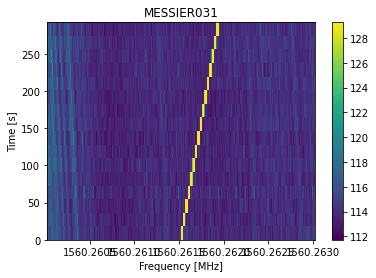

In [49]:
idx = 8

fb0 = bl.Waterfall('/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5', f_start=freqs[idx]-0.0015, f_stop=freqs[idx]+0.0015)
fb1 = bl.Waterfall('/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5', f_start=freqs[idx]-0.0015, f_stop=freqs[idx]+0.0015)
fb0.plot_waterfall()

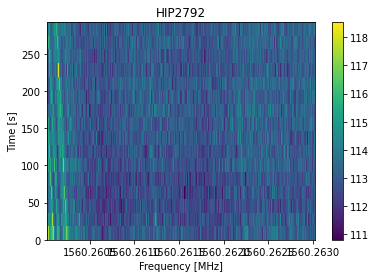

In [50]:
fb1.plot_waterfall()

In [28]:
all_dats = glob.glob('/datax/scratch/benjb/C23_L_M31_injections/*.dat')
for dat in all_dats:
    if 'MESSIER031' in dat:
        print(dat)
        #continue
        node = os.path.basename(dat)[:5]
        params = np.load(f'/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_{node}.npy', allow_pickle=True)
        freqs = params[0]
        #print(freqs)
        drifts = params[1]
        #print(drifts)
        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
        found_freqs = df['Uncorrected_Frequency'].values
        found_drifts = df['Drift_Rate'].values
        counter = 0
        for i, f in enumerate(freqs):
            subtract_vec = found_freqs - f
            if 0.0 in np.round(subtract_vec, -2):
                subtract_drift_vec = found_drifts + drifts[i]
                #print(np.min(np.abs(subtract_drift_vec)))
                if 0.0 in np.round(subtract_drift_vec, 1):
                    counter += 1
        print(counter)
        #break

/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
9
/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
24
/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
24
/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
13
/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
9
/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
10
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
9
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
9
/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
22
/datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_16209_MESSIER031_0057.gpus

In [5]:
csv_file = '/home/cgchoza/galaxies/complete_cadences_catalog.csv'

df = pd.read_csv(csv_file)
dfl = df.iloc[np.where(df['Band'].values == 'L')[0]]

del df
for line in dfl.iloc[np.where(dfl['Target'].values == 'MESSIER031')[0]]['.dat path'].values:
    if ('MESSIER031' in line) & (not 'blc71' in line) & (not 'blc76' in line):
        print(line)

/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc74_blp04/blc7

In [5]:
#for path in dfl['.h5 path'].values:
#    if 'MESSIER081' in path:
#        print(path)

/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5
/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_64288_MESSIER081_0059.rawspec.0000.h5
/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_64924_MESSIER081_0061.rawspec.0000.h5


In [13]:
'''n_inj = 100

h5_path = '/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5'

a, b, c, d = 1100, 1200, 1340, 1900
center_frequencies = np.random.uniform(a-b, d-c, n_inj)
center_frequencies += np.where(center_frequencies < 0, b, c)
drift_rates = np.random.uniform(-3.5, 3.5, n_inj)
snrs = np.random.uniform(1000, 20000, n_inj)
widths = np.random.randint(1, 4, n_inj)

wf = [bl.Waterfall(h5_path, f_start=center_frequencies[j]-0.007, f_stop=center_frequencies[j]+0.007) for j in range(n_inj)]

fb = bl.Waterfall(h5_path)
freqs, data = fb.grab_data()
header_dict = fb.header

for j in range(n_inj):
    c = stg.Frame(wf[j])
    block_freqs, _ = wf[j].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c.get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=widths[j]*c.df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data[:,np.where((freqs >= block_freqs[-1]) & (freqs <= block_freqs[0]))[0]] = np.flip(c.data, axis=1)

fb_new = bl.Waterfall(filename=None, header_dict=header_dict, data_array=np.expand_dims(data, axis=1))

fb_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M81_injections/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M81_injections/injections_freq_DR_snr_widths_MESSIER081.npy', np.array([center_frequencies, drift_rates, snrs, widths]))
'''

Adding signal 0 ...
Adding signal 1 ...
Adding signal 2 ...
Adding signal 3 ...
Adding signal 4 ...
Adding signal 5 ...
Adding signal 6 ...
Adding signal 7 ...
Adding signal 8 ...
Adding signal 9 ...
Adding signal 10 ...
Adding signal 11 ...
Adding signal 12 ...
Adding signal 13 ...
Adding signal 14 ...
Adding signal 15 ...
Adding signal 16 ...
Adding signal 17 ...
Adding signal 18 ...
Adding signal 19 ...
Adding signal 20 ...
Adding signal 21 ...
Adding signal 22 ...
Adding signal 23 ...
Adding signal 24 ...
Adding signal 25 ...
Adding signal 26 ...
Adding signal 27 ...
Adding signal 28 ...
Adding signal 29 ...
Adding signal 30 ...
Adding signal 31 ...
Adding signal 32 ...
Adding signal 33 ...
Adding signal 34 ...
Adding signal 35 ...
Adding signal 36 ...
Adding signal 37 ...
Adding signal 38 ...
Adding signal 39 ...
Adding signal 40 ...
Adding signal 41 ...
Adding signal 42 ...
Adding signal 43 ...
Adding signal 44 ...
Adding signal 45 ...
Adding signal 46 ...
Adding signal 47 ...
Ad

In [29]:
n_inj = 25

h5_list = ['/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
            '/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
            '/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
            '/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
            '/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
            '/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

print(f'Starting blc72 injection ...')
center_frequencies = np.random.uniform(1690, 1875, n_inj)
drift_rates = np.random.uniform(-3, 3, n_inj)
snrs = np.random.uniform(1000, 10000, n_inj)

print(f'Reading Waterfalls ...')
wf = [[bl.Waterfall(h5_list[i], f_start=center_frequencies[j]-0.006, f_stop=center_frequencies[j]+0.006) for i in range(6)] for j in range(n_inj)]
#wf = [bl.Waterfall(h5_list[i]) for i in range(6)]

print('Beginning Frame construction ...')

frame_list = []
for j in range(n_inj):
    cadence_frame_list = []
    for i in range(6):
        cadence_frame_list.append(stg.Frame(waterfall=wf[j][i]))
    frame_list.append(cadence_frame_list)

fb0 = bl.Waterfall(h5_list[0])
fb2 = bl.Waterfall(h5_list[2])
fb4 = bl.Waterfall(h5_list[4])
freqs0, data0 = fb0.grab_data()
header_dict0 = fb0.header
freqs2, data2 = fb2.grab_data()
header_dict2 = fb2.header
freqs4, data4 = fb4.grab_data()
header_dict4 = fb4.header

for j in range(n_inj):
    c = stg.Cadence(frame_list[j])
    block_freqs, _ = wf[j][0].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=1*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data0[:,np.where((freqs0 >= block_freqs[-1]) & (freqs0 <= block_freqs[0]))[0]] = np.flip(c[0].data, axis=1)
    data2[:,np.where((freqs2 >= block_freqs[-1]) & (freqs2 <= block_freqs[0]))[0]] = np.flip(c[2].data, axis=1)
    data4[:,np.where((freqs4 >= block_freqs[-1]) & (freqs4 <= block_freqs[0]))[0]] = np.flip(c[4].data, axis=1)

fb0_new = bl.Waterfall(filename=None, header_dict=header_dict0, data_array=np.expand_dims(data0, axis=1))
fb2_new = bl.Waterfall(filename=None, header_dict=header_dict2, data_array=np.expand_dims(data2, axis=1))
fb4_new = bl.Waterfall(filename=None, header_dict=header_dict4, data_array=np.expand_dims(data4, axis=1))

fb0_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb2_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5')
fb4_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc72.npy', np.array([center_frequencies, drift_rates, snrs]))

Starting blc72 injection ...
Reading Waterfalls ...


Beginning Frame construction ...
Adding signal 0 ...
Adding signal 1 ...
Adding signal 2 ...
Adding signal 3 ...
Adding signal 4 ...
Adding signal 5 ...
Adding signal 6 ...
Adding signal 7 ...
Adding signal 8 ...
Adding signal 9 ...
Adding signal 10 ...
Adding signal 11 ...
Adding signal 12 ...
Adding signal 13 ...
Adding signal 14 ...
Adding signal 15 ...
Adding signal 16 ...
Adding signal 17 ...
Adding signal 18 ...
Adding signal 19 ...
Adding signal 20 ...
Adding signal 21 ...
Adding signal 22 ...
Adding signal 23 ...
Adding signal 24 ...
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 5.27sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5 without blobbing.
blimpy.wa

In [30]:
n_inj = 25

h5_list = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

print(f'Starting blc73 injection ...')
center_frequencies = np.random.uniform(1502, 1688, n_inj)
drift_rates = np.random.uniform(-3, 3, n_inj)
snrs = np.random.uniform(1000, 10000, n_inj)

print(f'Reading Waterfalls ...')
wf = [[bl.Waterfall(h5_list[i], f_start=center_frequencies[j]-0.006, f_stop=center_frequencies[j]+0.006) for i in range(6)] for j in range(n_inj)]
#wf = [bl.Waterfall(h5_list[i]) for i in range(6)]

print('Beginning Frame construction ...')

frame_list = []
for j in range(n_inj):
    cadence_frame_list = []
    for i in range(6):
        cadence_frame_list.append(stg.Frame(waterfall=wf[j][i]))
    frame_list.append(cadence_frame_list)

fb0 = bl.Waterfall(h5_list[0])
fb2 = bl.Waterfall(h5_list[2])
fb4 = bl.Waterfall(h5_list[4])
freqs0, data0 = fb0.grab_data()
header_dict0 = fb0.header
freqs2, data2 = fb2.grab_data()
header_dict2 = fb2.header
freqs4, data4 = fb4.grab_data()
header_dict4 = fb4.header

for j in range(n_inj):
    c = stg.Cadence(frame_list[j])
    block_freqs, _ = wf[j][0].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=1*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data0[:,np.where((freqs0 >= block_freqs[-1]) & (freqs0 <= block_freqs[0]))[0]] = np.flip(c[0].data, axis=1)
    data2[:,np.where((freqs2 >= block_freqs[-1]) & (freqs2 <= block_freqs[0]))[0]] = np.flip(c[2].data, axis=1)
    data4[:,np.where((freqs4 >= block_freqs[-1]) & (freqs4 <= block_freqs[0]))[0]] = np.flip(c[4].data, axis=1)

fb0_new = bl.Waterfall(filename=None, header_dict=header_dict0, data_array=np.expand_dims(data0, axis=1))
fb2_new = bl.Waterfall(filename=None, header_dict=header_dict2, data_array=np.expand_dims(data2, axis=1))
fb4_new = bl.Waterfall(filename=None, header_dict=header_dict4, data_array=np.expand_dims(data4, axis=1))

fb0_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb2_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5')
fb4_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc73.npy', np.array([center_frequencies, drift_rates, snrs]))

Starting blc73 injection ...
Reading Waterfalls ...
Beginning Frame construction ...
Adding signal 0 ...
Adding signal 1 ...
Adding signal 2 ...
Adding signal 3 ...
Adding signal 4 ...
Adding signal 5 ...
Adding signal 6 ...
Adding signal 7 ...
Adding signal 8 ...
Adding signal 9 ...
Adding signal 10 ...
Adding signal 11 ...
Adding signal 12 ...
Adding signal 13 ...
Adding signal 14 ...
Adding signal 15 ...
Adding signal 16 ...
Adding signal 17 ...
Adding signal 18 ...
Adding signal 19 ...
Adding signal 20 ...
Adding signal 21 ...
Adding signal 22 ...
Adding signal 23 ...
Adding signal 24 ...
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 5.29sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER

In [3]:
n_inj = 25

h5_list = ['/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc74_blp04/blc74_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

print(f'Starting blc74 injection ...')
center_frequencies = np.random.uniform(1350, 1500, n_inj)
drift_rates = np.random.uniform(-3, 3, n_inj)
snrs = np.random.uniform(1000, 10000, n_inj)

print(f'Reading Waterfalls ...')
wf = [[bl.Waterfall(h5_list[i], f_start=center_frequencies[j]-0.006, f_stop=center_frequencies[j]+0.006) for i in range(6)] for j in range(n_inj)]
#wf = [bl.Waterfall(h5_list[i]) for i in range(6)]

print('Beginning Frame construction ...')

frame_list = []
for j in range(n_inj):
    cadence_frame_list = []
    for i in range(6):
        cadence_frame_list.append(stg.Frame(waterfall=wf[j][i]))
    frame_list.append(cadence_frame_list)

fb0 = bl.Waterfall(h5_list[0])
fb2 = bl.Waterfall(h5_list[2])
fb4 = bl.Waterfall(h5_list[4])
freqs0, data0 = fb0.grab_data()
header_dict0 = fb0.header
freqs2, data2 = fb2.grab_data()
header_dict2 = fb2.header
freqs4, data4 = fb4.grab_data()
header_dict4 = fb4.header

for j in range(n_inj):
    c = stg.Cadence(frame_list[j])
    block_freqs, _ = wf[j][0].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=1*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data0[:,np.where((freqs0 >= block_freqs[-1]) & (freqs0 <= block_freqs[0]))[0]] = np.flip(c[0].data, axis=1)
    data2[:,np.where((freqs2 >= block_freqs[-1]) & (freqs2 <= block_freqs[0]))[0]] = np.flip(c[2].data, axis=1)
    data4[:,np.where((freqs4 >= block_freqs[-1]) & (freqs4 <= block_freqs[0]))[0]] = np.flip(c[4].data, axis=1)

fb0_new = bl.Waterfall(filename=None, header_dict=header_dict0, data_array=np.expand_dims(data0, axis=1))
fb2_new = bl.Waterfall(filename=None, header_dict=header_dict2, data_array=np.expand_dims(data2, axis=1))
fb4_new = bl.Waterfall(filename=None, header_dict=header_dict4, data_array=np.expand_dims(data4, axis=1))

fb0_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb2_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5')
fb4_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc74.npy', np.array([center_frequencies, drift_rates, snrs]))

Starting blc74 injection ...
Reading Waterfalls ...
Beginning Frame construction ...
Adding signal 0 ...
Adding signal 1 ...
Adding signal 2 ...
Adding signal 3 ...
Adding signal 4 ...
Adding signal 5 ...
Adding signal 6 ...
Adding signal 7 ...
Adding signal 8 ...
Adding signal 9 ...
Adding signal 10 ...
Adding signal 11 ...
Adding signal 12 ...
Adding signal 13 ...
Adding signal 14 ...
Adding signal 15 ...
Adding signal 16 ...
Adding signal 17 ...
Adding signal 18 ...
Adding signal 19 ...
Adding signal 20 ...
Adding signal 21 ...
Adding signal 22 ...
Adding signal 23 ...
Adding signal 24 ...
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 5.23sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16851_MESSIER

In [11]:
#arr = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc74.npy')
#freqs = arr[0]
#drifts = arr[1]
#snrs = arr[2]

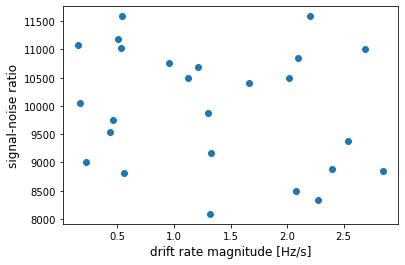

In [13]:
#plt.scatter(np.abs(drifts), snrs)
#plt.scatter(np.abs(unfound_drifts), unfound_snrs)
#plt.xlabel('drift rate magnitude [Hz/s]', size=12)
#plt.ylabel('signal-noise ratio', size=12)
#plt.show()

In [15]:
#arr = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc75.npy')
#freqs = arr[0]
#drifts = arr[1]
#snrs = arr[2]
#df = pd.read_table('/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
#                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
#                                            'Full_number_of_hits'], skiprows=9)
#table_freqs = df['Uncorrected_Frequency'].values
#table_drifts = df['Drift_Rate'].values
#table_snrs = df['SNR'].values
#unfound_drifts = []
#unfound_snrs = []
#for i in range(len(freqs)):
#    vec = np.round(table_freqs - freqs[i], 2)
#    if not 0 in vec:
#        unfound_drifts.append(drifts[i])
#        unfound_snrs.append(snrs[i])
#        print(freqs[i])

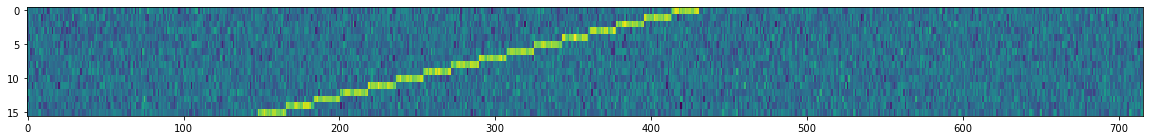

In [5]:
#fb = bl.Waterfall('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
#                  f_start=1428.381, f_stop=1428.383)
#fig = plt.figure(figsize=(20, 2))
#plt.imshow(np.log10(np.squeeze(fb.data))**2, aspect='auto', interpolation='none')

In [14]:
n_inj = 25

h5_list = ['/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
       '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

print(f'Starting blc75 injection ...')
center_frequencies = np.random.uniform(1127, 1199, n_inj)
drift_rates = np.random.uniform(-3, 3, n_inj)
snrs = np.random.uniform(1000, 10000, n_inj)

print(f'Reading Waterfalls ...')
wf = [[bl.Waterfall(h5_list[i], f_start=center_frequencies[j]-0.006, f_stop=center_frequencies[j]+0.006) for i in range(6)] for j in range(n_inj)]
#wf = [bl.Waterfall(h5_list[i]) for i in range(6)]

print('Beginning Frame construction ...')

frame_list = []
for j in range(n_inj):
    cadence_frame_list = []
    for i in range(6):
        cadence_frame_list.append(stg.Frame(waterfall=wf[j][i]))
    frame_list.append(cadence_frame_list)

fb0 = bl.Waterfall(h5_list[0])
fb2 = bl.Waterfall(h5_list[2])
fb4 = bl.Waterfall(h5_list[4])
freqs0, data0 = fb0.grab_data()
header_dict0 = fb0.header
freqs2, data2 = fb2.grab_data()
header_dict2 = fb2.header
freqs4, data4 = fb4.grab_data()
header_dict4 = fb4.header

for j in range(n_inj):
    c = stg.Cadence(frame_list[j])
    block_freqs, _ = wf[j][0].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=1*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data0[:,np.where((freqs0 >= block_freqs[-1]) & (freqs0 <= block_freqs[0]))[0]] = np.flip(c[0].data, axis=1)
    data2[:,np.where((freqs2 >= block_freqs[-1]) & (freqs2 <= block_freqs[0]))[0]] = np.flip(c[2].data, axis=1)
    data4[:,np.where((freqs4 >= block_freqs[-1]) & (freqs4 <= block_freqs[0]))[0]] = np.flip(c[4].data, axis=1)

fb0_new = bl.Waterfall(filename=None, header_dict=header_dict0, data_array=np.expand_dims(data0, axis=1))
fb2_new = bl.Waterfall(filename=None, header_dict=header_dict2, data_array=np.expand_dims(data2, axis=1))
fb4_new = bl.Waterfall(filename=None, header_dict=header_dict4, data_array=np.expand_dims(data4, axis=1))

fb0_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb2_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5')
fb4_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc75.npy', np.array([center_frequencies, drift_rates, snrs]))

Starting blc75 injection ...
Reading Waterfalls ...
Beginning Frame construction ...
Adding signal 0 ...
Adding signal 1 ...
Adding signal 2 ...
Adding signal 3 ...
Adding signal 4 ...
Adding signal 5 ...
Adding signal 6 ...
Adding signal 7 ...
Adding signal 8 ...
Adding signal 9 ...
Adding signal 10 ...
Adding signal 11 ...
Adding signal 12 ...
Adding signal 13 ...
Adding signal 14 ...
Adding signal 15 ...
Adding signal 16 ...
Adding signal 17 ...
Adding signal 18 ...
Adding signal 19 ...
Adding signal 20 ...
Adding signal 21 ...
Adding signal 22 ...
Adding signal 23 ...
Adding signal 24 ...
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 5.02sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER